In [4]:
import eeg_decoder
import numpy as np
%load_ext autoreload
%autoreload 2

In [22]:
# Experiment setup
experiment_name1 = '1801'
experiment_name2 = '1901'
experiment_name3 = '1902'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'
data_dir3 = f'./data/{experiment_name3}'

exp1 = eeg_decoder.Experiment(experiment_name1,data_dir1)
exp2 = eeg_decoder.Experiment(experiment_name2,data_dir2)
exp3 = eeg_decoder.Experiment(experiment_name3,data_dir3)

In [25]:
# Classification parameters and setup
time_window = 50
time_step = 25
trial_bin_size = 20
n_splits = 30 
group_dict = {0:[1],1:[3]}
wrangl = eeg_decoder.Wrangler(exp1.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)

sync = eeg_decoder.Experiment_Syncer(experiments=[exp1,exp2,exp3],
                                    wrangler = wrangl,
                                    train_group = [exp1.experiment_name,exp2.experiment_name])

clfr = eeg_decoder.Classification(wrangl,sync.nsub,num_labels=2)

In [31]:
for isub,sub in enumerate(sync.matched_ids):
    print(isub)
    xdata,ydata = sync.load_eeg(sub)
    xdata,ydata = sync.group_labels(xdata,ydata)
    xdata_train,xdata_test,ydata_train,ydata_test = sync.group_data(xdata,ydata)
    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_custom_split(xdata_train,xdata_test,ydata_train,ydata_test,test_size=.5):
        X_train_all, X_test_all, y_train, y_test = wrangl.bin_and_balance_data(X_train_all, X_test_all, y_train, y_test) 
        y_test_shuffle = np.random.permutation(y_test)
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle, isub)

0
1


In [33]:
interp = eeg_decoder.Interpreter(clfr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


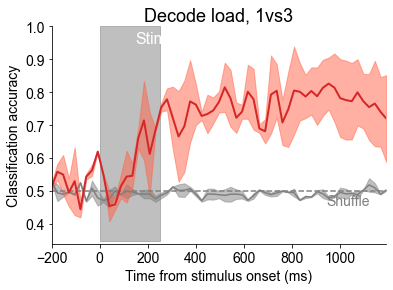

Mean delay accuracy: 0.7629646164021164
Mean delay S.D.: 0.03968002978586997


In [34]:
interp.plot_acc(significance_testing=False,savefig=False,ylim=[.34,1],chance_text_y=.23, title='Decode load, 1vs3')